In [1]:
import utils
import torch
import random
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

In [2]:
tracks_to_genre = utils.load_csv("tracks")["track"]
train_ids, validate_ids, test_ids = utils.load_ids()
chroma_type = "chroma_cqt"
train_set, validate_set, test_set = utils.load_features(chroma_type)

genres = list(set(tracks_to_genre["genre_top"]))

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(12, 12, 5)
        self.conv2 = nn.Conv2d(1, 1, 5)
        self.conv3 = nn.Conv1d(4, 4, 5)
        self.maxpool1 = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(4 * 36, 120)
        self.fc2 = nn.Linear(120, 36)
        self.fc3 = nn.Linear(36, 8)
    
    def forward(self, input):
        output = self.maxpool1(functional.relu(self.conv1(input)))
        output = output[None, :, :, :]
        output = self.maxpool2(functional.relu(self.conv2(output)))
        output = torch.squeeze(output, dim=0)
        output = self.maxpool1(functional.relu(self.conv3(output)))

        output = torch.flatten(output)
        output = functional.relu(self.fc1(output))
        output = functional.relu(self.fc2(output))
        output = self.fc3(output)

        return output


In [4]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [5]:
def random_training_example():
    random_int = random.randint(0, len(train_ids) - 1)
    id = train_ids[random_int]
    genre = tracks_to_genre.loc[id]["genre_top"]
    genre_tensor = torch.tensor([genres.index(genre)])
    feature_tensor = train_set[random_int][None, :, :]

    return feature_tensor, genre, genre_tensor

def train(feature_tensor, genre_tensor):
    optimizer.zero_grad()
    output = cnn(feature_tensor)
    loss = criterion(output[None, :], genre_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

def genre_from_output(output):
    top_val, top_i = output.topk(1)
    genre_i = top_i[0].item()
    return genres[genre_i], genre_i

In [6]:
n_iters = 6400
current_loss = 0
all_losses = []
print_every = 1000
plot_every = 1000

start = time.time()
for epoch in range(5):
    for i in range(1, n_iters + 1):
        feature_tensor, genre, genre_tensor = random_training_example()
        output, loss = train(feature_tensor, genre_tensor)
        current_loss += loss

        if i % print_every == 0:
            print(f"{utils.time_since(start)}, epoch {epoch}, iter {i}, loss: {current_loss}, Predict: {genre_from_output(output)}, Actual: {genre}")
        
        if i % plot_every == 0:
            all_losses.append(current_loss)
            current_loss = 0


0min 7.7s, epoch 0, iter 1000, loss: 2084.2364432811737, Predict: ('Electronic', 5), Actual: Rock
0min 16.2s, epoch 0, iter 2000, loss: 2082.636913061142, Predict: ('Electronic', 5), Actual: Instrumental
0min 24.1s, epoch 0, iter 3000, loss: 2080.9771760702133, Predict: ('Rock', 4), Actual: Experimental
0min 32.6s, epoch 0, iter 4000, loss: 2081.2100055217743, Predict: ('Hip-Hop', 3), Actual: Instrumental
0min 38.3s, epoch 0, iter 5000, loss: 2081.3023324012756, Predict: ('Pop', 1), Actual: Rock
0min 43.9s, epoch 0, iter 6000, loss: 2080.8768125772476, Predict: ('Hip-Hop', 3), Actual: Experimental
0min 53.0s, epoch 1, iter 1000, loss: 2912.0238242149353, Predict: ('Pop', 1), Actual: Electronic
0min 59.5s, epoch 1, iter 2000, loss: 2081.306818962097, Predict: ('Hip-Hop', 3), Actual: Rock
1min 8.2s, epoch 1, iter 3000, loss: 2080.5754803419113, Predict: ('Hip-Hop', 3), Actual: Rock
1min 16.9s, epoch 1, iter 4000, loss: 2080.855503320694, Predict: ('International', 0), Actual: Pop
1min 25

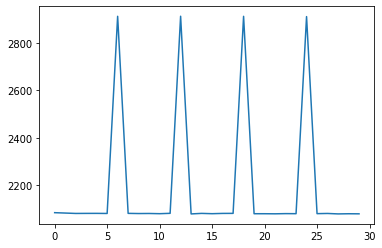

In [7]:
import matplotlib.pyplot as plt

plt.plot(all_losses)